In [1]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

### Data preparation

In [3]:
# Load data
faults = pd.read_csv('Failure_Senja grid 12.csv')
faults_clean = faults.dropna(axis='rows', how='any')
X = faults_clean.values[:,1:-1].astype(np.float32)
y = faults_clean.values[:,-1].astype(np.int)
feature_names = faults_clean.columns[1:5]

# Subsample the non-fault class
sampling_rate=6
neg_idx = np.where(y==0)[0]
delete_idx = np.setdiff1d(neg_idx, neg_idx[::sampling_rate])
y = np.delete(y, delete_idx)
X = np.delete(X, delete_idx, axis=0)

# Examine the class imbalanceness
neg, pos = np.bincount(y)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))

# Split and shuffle the dataset
train_features, test_features, train_labels, test_labels = train_test_split(
    X, y, test_size=0.2, stratify=y, shuffle=True)
train_features, val_features, train_labels, val_labels = train_test_split(
    train_features, train_labels, test_size=0.2, stratify=train_labels, shuffle=True)

Examples:
    Total: 16569
    Positive: 90 (0.54% of total)



In [4]:
# Normalize the features
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

Training features shape: (10604, 12)
Validation features shape: (2651, 12)
Test features shape: (3314, 12)
Training labels shape: (10604,)
Validation labels shape: (2651,)
Test labels shape: (3314,)


Next, we look at data distributions.

It would be nice to see differences between the distributions of pos and neg samples, but we don't see much when considering active and reactive power

C:\Users\fmbia\anaconda3\envs\spektral_tf2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\fmbia\anaconda3\envs\spektral_tf2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\fmbia\anaconda3\envs\spektral_tf2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misint

Text(0.5, 0.98, 'Negative distribution')

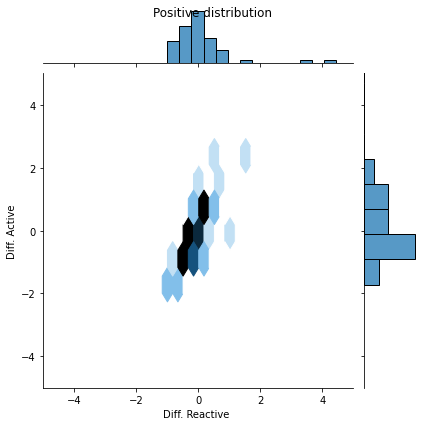

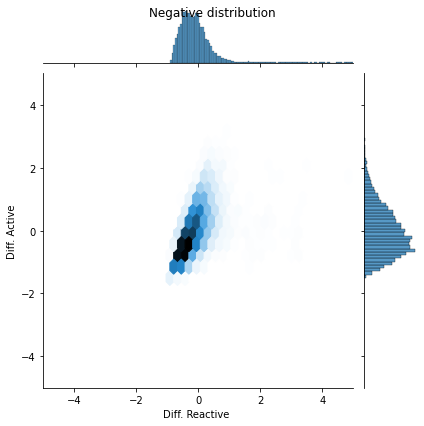

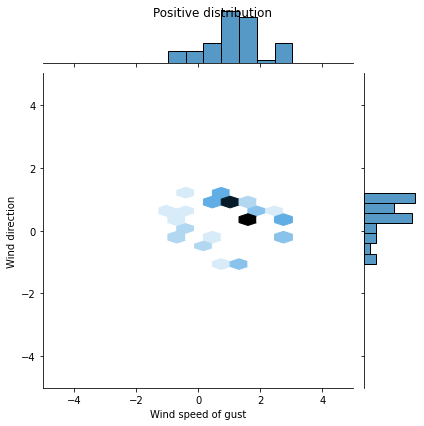

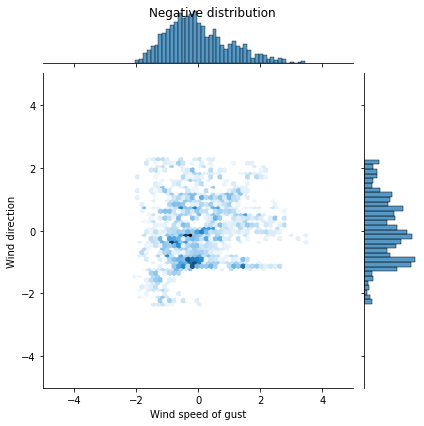

In [4]:
pos_df = pd.DataFrame(train_features[train_labels==1], columns=feature_names)
neg_df = pd.DataFrame(train_features[train_labels==0], columns=feature_names)


sns.jointplot(pos_df['Diff. Reactive '], pos_df['Diff. Active'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(neg_df['Diff. Reactive '], neg_df['Diff. Active'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Negative distribution")

sns.jointplot(pos_df['Wind speed of gust'], pos_df['Wind direction'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(neg_df['Wind speed of gust'], neg_df['Wind direction'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Negative distribution")

### Definition of the MLP model

There are many different options to build a MLP. This is a very simple model, but not necessarily the best one.

In [5]:
# Metrics that are monitored during training
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(32, activation='relu',
                         kernel_regularizer=tf.keras.regularizers.l2(1e-4),
                         input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(32, activation='relu',
                        kernel_regularizer=tf.keras.regularizers.l2(1e-4),),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

### 1. Baseline model

In [6]:
EPOCHS = 1000
BATCH_SIZE = 1028

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=30,
    mode='max',
    restore_best_weights=True)


model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                160       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,249
Trainable params: 1,249
Non-trainable params: 0
_________________________________________________________________


Setup a bias that accounts for class imbalanceness:

$$ p_0 = pos/(pos+neg) = 1/(1+e^{-b_0})$$
$$b_0 = -log_e(1/p_0 -1)$$
$$b_0 = log_e(pos/neg)$$

With this initialization the initial loss should be approx

$$-p_0 log(p_0) - (1- p_0)log(1-p_0)$$

This initial loss is much lower than it would have been with the naive initialization.
This way the model doesn't need to spend the first few epochs just learning that positive examples are unlikely. This also makes it easier to read plots of the loss during training.

In [7]:
initial_bias = np.log([pos/neg])

In [8]:
# Train the model
model = make_model(output_bias=initial_bias)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/1000
10/10 [==============================] - 1s 102ms/step - loss: 0.0461 - tp: 1.0000 - fp: 11.0000 - tn: 9195.0000 - fn: 56.0000 - accuracy: 0.9928 - precision: 0.0833 - recall: 0.0175 - auc: 0.4674 - prc: 0.0198 - val_loss: 0.0421 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 2302.0000 - val_fn: 14.0000 - val_accuracy: 0.9940 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3104 - val_prc: 0.0040
Epoch 2/1000
10/10 [==============================] - 0s 8ms/step - loss: 0.0454 - tp: 2.0000 - fp: 8.0000 - tn: 9198.0000 - fn: 55.0000 - accuracy: 0.9932 - precision: 0.2000 - recall: 0.0351 - auc: 0.4345 - prc: 0.0135 - val_loss: 0.0414 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 2302.0000 - val_fn: 14.0000 - val_accuracy: 0.9940 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4063 - val_prc: 0.0047
Epoch 3/1000
10/10 [==============================] - 0s 8ms/step - loss: 0.0456 - tp: 1.0000 - fp: 9.0000 - tn: 9197.0000 - fn: 56.0

Epoch 20/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.0377 - tp: 3.0000 - fp: 2.0000 - tn: 9204.0000 - fn: 54.0000 - accuracy: 0.9940 - precision: 0.6000 - recall: 0.0526 - auc: 0.7346 - prc: 0.0624 - val_loss: 0.0381 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 2302.0000 - val_fn: 14.0000 - val_accuracy: 0.9940 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7261 - val_prc: 0.0250
Epoch 21/1000
10/10 [==============================] - 0s 8ms/step - loss: 0.0375 - tp: 3.0000 - fp: 2.0000 - tn: 9204.0000 - fn: 54.0000 - accuracy: 0.9940 - precision: 0.6000 - recall: 0.0526 - auc: 0.7123 - prc: 0.0771 - val_loss: 0.0381 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 2302.0000 - val_fn: 14.0000 - val_accuracy: 0.9940 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7252 - val_prc: 0.0226
Epoch 22/1000
10/10 [==============================] - 0s 8ms/step - loss: 0.0358 - tp: 2.0000 - fp: 0.0000e+00 - tn: 9206.0000 - fn: 

Epoch 39/1000
10/10 [==============================] - 0s 8ms/step - loss: 0.0359 - tp: 3.0000 - fp: 2.0000 - tn: 9204.0000 - fn: 54.0000 - accuracy: 0.9940 - precision: 0.6000 - recall: 0.0526 - auc: 0.7344 - prc: 0.0767 - val_loss: 0.0371 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 2302.0000 - val_fn: 14.0000 - val_accuracy: 0.9940 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7201 - val_prc: 0.0336
Epoch 40/1000
10/10 [==============================] - 0s 8ms/step - loss: 0.0344 - tp: 4.0000 - fp: 0.0000e+00 - tn: 9206.0000 - fn: 53.0000 - accuracy: 0.9943 - precision: 1.0000 - recall: 0.0702 - auc: 0.7846 - prc: 0.1161 - val_loss: 0.0371 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 2302.0000 - val_fn: 14.0000 - val_accuracy: 0.9940 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7228 - val_prc: 0.0337
Epoch 41/1000
10/10 [==============================] - 0s 8ms/step - loss: 0.0359 - tp: 2.0000 - fp: 2.0000 - tn: 9204.0000 - fn: 

loss :  0.03626665845513344
tp :  1.0
fp :  0.0
tn :  2877.0
fn :  17.0
accuracy :  0.9941278100013733
precision :  1.0
recall :  0.0555555559694767
auc :  0.8110203146934509
prc :  0.09163433313369751



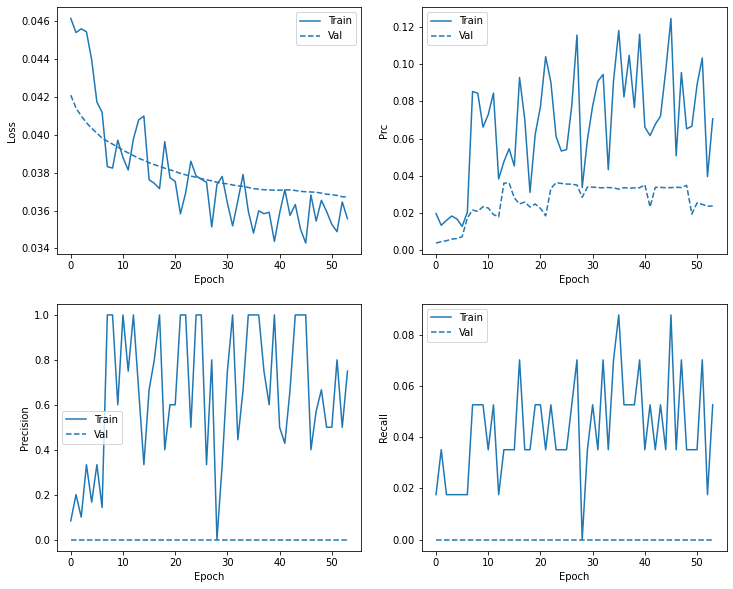

In [9]:
# Function that plots how the metrics on training and validation set change during the training
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()
    
# Make the plots
plot_metrics(baseline_history)

# Print the value of the metrics at the end of the training
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

True Negatives:  2877
False Positives:  0
False Negatives:  17
True Positives:  1
Total faults:  18


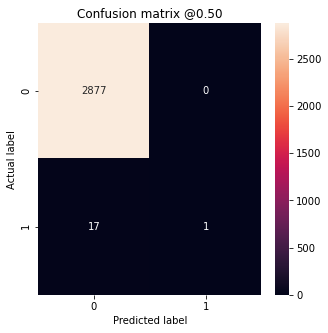

In [10]:
# Function to plot the confusion matrix
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])
  print('Total faults: ', np.sum(cm[1]))

# Get the predicted labels and compute the CM 
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)
plot_cm(test_labels, test_predictions_baseline, p=0.5)

### 2. Model with adjusted class weights to account for class imbalance

In [11]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 81.31


In [12]:
# Train
weighted_model = make_model(output_bias=initial_bias)
weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    class_weight=class_weight)

Epoch 1/1000
10/10 [==============================] - 1s 108ms/step - loss: 2.2153 - tp: 5.0000 - fp: 20.0000 - tn: 12063.0000 - fn: 70.0000 - accuracy: 0.9926 - precision: 0.2000 - recall: 0.0667 - auc: 0.5903 - prc: 0.0387 - val_loss: 0.0418 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 2302.0000 - val_fn: 14.0000 - val_accuracy: 0.9940 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5479 - val_prc: 0.0780
Epoch 2/1000
10/10 [==============================] - 0s 8ms/step - loss: 1.8683 - tp: 8.0000 - fp: 27.0000 - tn: 9179.0000 - fn: 49.0000 - accuracy: 0.9918 - precision: 0.2286 - recall: 0.1404 - auc: 0.6491 - prc: 0.0668 - val_loss: 0.0434 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 2302.0000 - val_fn: 14.0000 - val_accuracy: 0.9940 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5879 - val_prc: 0.0788
Epoch 3/1000
10/10 [==============================] - 0s 9ms/step - loss: 1.7594 - tp: 7.0000 - fp: 50.0000 - tn: 9156.0000 - fn: 5

loss :  0.04192889481782913
tp :  1.0
fp :  0.0
tn :  2877.0
fn :  17.0
accuracy :  0.9941278100013733
precision :  1.0
recall :  0.0555555559694767
auc :  0.6623026132583618
prc :  0.0765247493982315



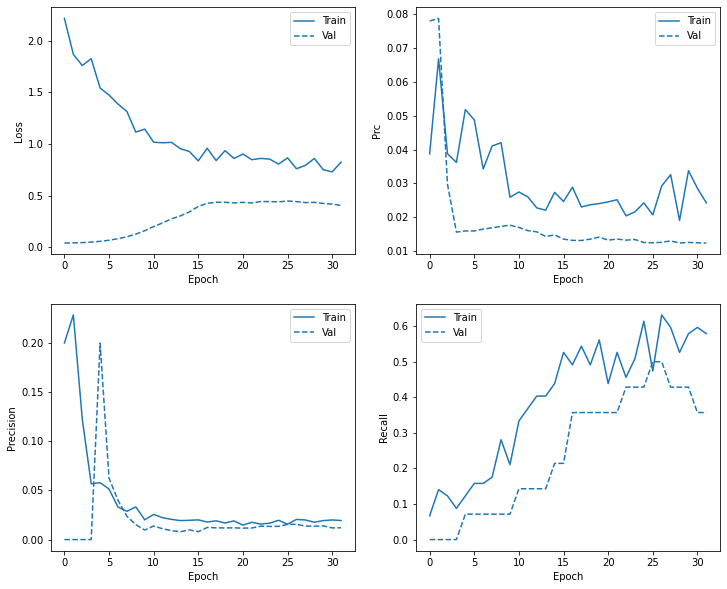

In [13]:
# Plot metrics history
plot_metrics(weighted_history)

# Print metrics and the end of training
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

True Negatives:  2877
False Positives:  0
False Negatives:  17
True Positives:  1
Total faults:  18


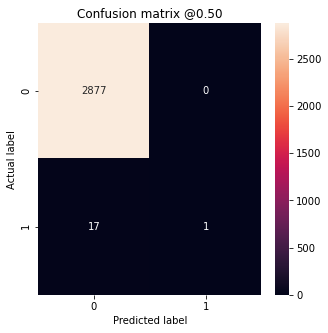

In [14]:
# Confusion matrix
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)
plot_cm(test_labels, test_predictions_weighted, p=0.5)

### 3. Oversampling

We artificially oversample the minority class

In [15]:
pos_features = train_features[train_labels==1]
neg_features = train_features[train_labels==0]
pos_labels = train_labels[train_labels==1]
neg_labels = train_labels[train_labels==0]

# Balance the dataset manually by choosing the right number of random indices from the positive examples
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))
res_pos_features = pos_features[choices] # Resampled training features
res_pos_labels = pos_labels[choices] # Resampled training labels

# We concatenate the resampled positive samples with the negative samples
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

# We shuffle the data
order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(18412, 4)

If the training process was considering the whole dataset on each gradient update, this oversampling would be basically identical to the class weighting.

But when training the model batch-wise, the oversampled data provides a smoother gradient signal: Instead of each positive example being shown in one batch with a large weight, they're shown in many different batches each time with a small weight.

This smoother gradient signal makes it easier to train the model.

In [16]:
# Now the bias should be zero, since this dataset is balanced.
resampled_model = make_model()
resampled_history = resampled_model.fit(
    resampled_features,
    resampled_labels,
    epochs=EPOCHS,
    batch_size=32,    # now we can reduce the batch size
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/1000
576/576 [==============================] - 4s 7ms/step - loss: 0.6397 - tp: 7639.0000 - fp: 4632.0000 - tn: 7451.0000 - fn: 1585.0000 - accuracy: 0.7082 - precision: 0.6225 - recall: 0.8282 - auc: 0.7967 - prc: 0.7243 - val_loss: 0.5611 - val_tp: 11.0000 - val_fp: 695.0000 - val_tn: 1607.0000 - val_fn: 3.0000 - val_accuracy: 0.6986 - val_precision: 0.0156 - val_recall: 0.7857 - val_auc: 0.7755 - val_prc: 0.0181
Epoch 2/1000
576/576 [==============================] - 3s 5ms/step - loss: 0.5289 - tp: 7476.0000 - fp: 3127.0000 - tn: 6079.0000 - fn: 1730.0000 - accuracy: 0.7362 - precision: 0.7051 - recall: 0.8121 - auc: 0.8160 - prc: 0.8069 - val_loss: 0.4981 - val_tp: 11.0000 - val_fp: 652.0000 - val_tn: 1650.0000 - val_fn: 3.0000 - val_accuracy: 0.7172 - val_precision: 0.0166 - val_recall: 0.7857 - val_auc: 0.7812 - val_prc: 0.0232
Epoch 3/1000
576/576 [==============================] - 3s 5ms/step - loss: 0.5049 - tp: 7523.0000 - fp: 2928.0000 - tn: 6278.0000 - fn: 1683.00

576/576 [==============================] - 3s 6ms/step - loss: 0.3773 - tp: 8320.0000 - fp: 2228.0000 - tn: 6978.0000 - fn: 886.0000 - accuracy: 0.8309 - precision: 0.7888 - recall: 0.9038 - auc: 0.9058 - prc: 0.8871 - val_loss: 0.4048 - val_tp: 11.0000 - val_fp: 556.0000 - val_tn: 1746.0000 - val_fn: 3.0000 - val_accuracy: 0.7586 - val_precision: 0.0194 - val_recall: 0.7857 - val_auc: 0.8151 - val_prc: 0.0949
Epoch 40/1000
576/576 [==============================] - 3s 5ms/step - loss: 0.3738 - tp: 8260.0000 - fp: 2206.0000 - tn: 7000.0000 - fn: 946.0000 - accuracy: 0.8288 - precision: 0.7892 - recall: 0.8972 - auc: 0.9084 - prc: 0.8917 - val_loss: 0.4149 - val_tp: 11.0000 - val_fp: 589.0000 - val_tn: 1713.0000 - val_fn: 3.0000 - val_accuracy: 0.7444 - val_precision: 0.0183 - val_recall: 0.7857 - val_auc: 0.8189 - val_prc: 0.0972
Epoch 41/1000
576/576 [==============================] - 3s 5ms/step - loss: 0.3694 - tp: 8345.0000 - fp: 2240.0000 - tn: 6966.0000 - fn: 861.0000 - accuracy:

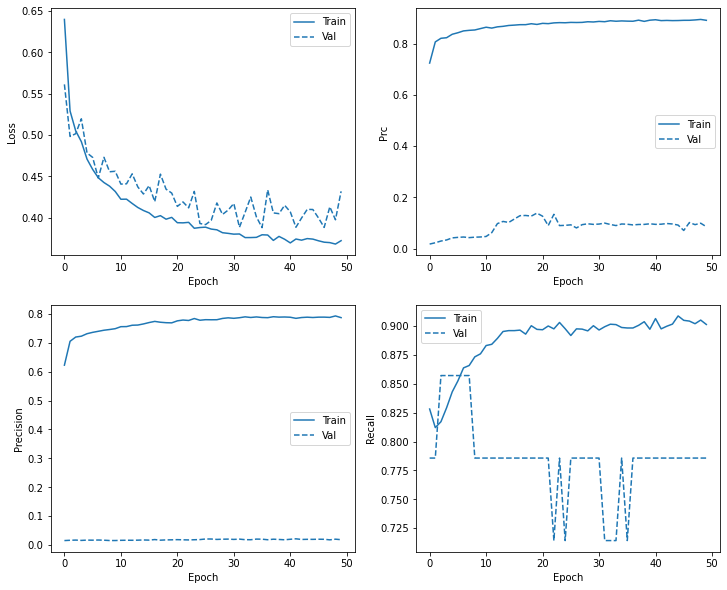

In [17]:
plot_metrics(resampled_history)

In [18]:
# Since this model can overfit easily, we retrain it a second time.
# We break up the epochs to give the callbacks.EarlyStopping finer control over when to stop training.
resampled_history = resampled_model.fit(
    resampled_features,
    resampled_labels,
    # These are not real epochs. 
    steps_per_epoch=20,
    epochs=10*EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/10000
20/20 [==============================] - 0s 21ms/step - loss: 0.3944 - tp: 8322.0000 - fp: 2482.0000 - tn: 6724.0000 - fn: 884.0000 - accuracy: 0.8172 - precision: 0.7703 - recall: 0.9040 - auc: 0.8983 - prc: 0.8810 - val_loss: 0.4373 - val_tp: 11.0000 - val_fp: 603.0000 - val_tn: 1699.0000 - val_fn: 3.0000 - val_accuracy: 0.7383 - val_precision: 0.0179 - val_recall: 0.7857 - val_auc: 0.8046 - val_prc: 0.1384
Epoch 2/10000
20/20 [==============================] - 0s 20ms/step - loss: 0.3909 - tp: 8363.0000 - fp: 2419.0000 - tn: 6787.0000 - fn: 843.0000 - accuracy: 0.8228 - precision: 0.7756 - recall: 0.9084 - auc: 0.9000 - prc: 0.8806 - val_loss: 0.4315 - val_tp: 11.0000 - val_fp: 597.0000 - val_tn: 1705.0000 - val_fn: 3.0000 - val_accuracy: 0.7409 - val_precision: 0.0181 - val_recall: 0.7857 - val_auc: 0.8052 - val_prc: 0.1321
Epoch 3/10000
20/20 [==============================] - 0s 20ms/step - loss: 0.3929 - tp: 8325.0000 - fp: 2423.0000 - tn: 6783.0000 - fn: 881.0000 

20/20 [==============================] - 0s 21ms/step - loss: 0.3860 - tp: 8310.0000 - fp: 2296.0000 - tn: 6910.0000 - fn: 896.0000 - accuracy: 0.8266 - precision: 0.7835 - recall: 0.9027 - auc: 0.9029 - prc: 0.8848 - val_loss: 0.4145 - val_tp: 11.0000 - val_fp: 557.0000 - val_tn: 1745.0000 - val_fn: 3.0000 - val_accuracy: 0.7582 - val_precision: 0.0194 - val_recall: 0.7857 - val_auc: 0.8078 - val_prc: 0.0909
Epoch 40/10000
20/20 [==============================] - 0s 21ms/step - loss: 0.3847 - tp: 8295.0000 - fp: 2316.0000 - tn: 6890.0000 - fn: 911.0000 - accuracy: 0.8247 - precision: 0.7817 - recall: 0.9010 - auc: 0.9033 - prc: 0.8854 - val_loss: 0.4148 - val_tp: 11.0000 - val_fp: 556.0000 - val_tn: 1746.0000 - val_fn: 3.0000 - val_accuracy: 0.7586 - val_precision: 0.0194 - val_recall: 0.7857 - val_auc: 0.8075 - val_prc: 0.0909
Epoch 41/10000
20/20 [==============================] - 0s 21ms/step - loss: 0.3868 - tp: 8281.0000 - fp: 2328.0000 - tn: 6878.0000 - fn: 925.0000 - accuracy: 

loss :  0.41382476687431335
tp :  17.0
fp :  688.0
tn :  2189.0
fn :  1.0
accuracy :  0.762003481388092
precision :  0.024113474413752556
recall :  0.9444444179534912
auc :  0.9111729264259338
prc :  0.2816297709941864



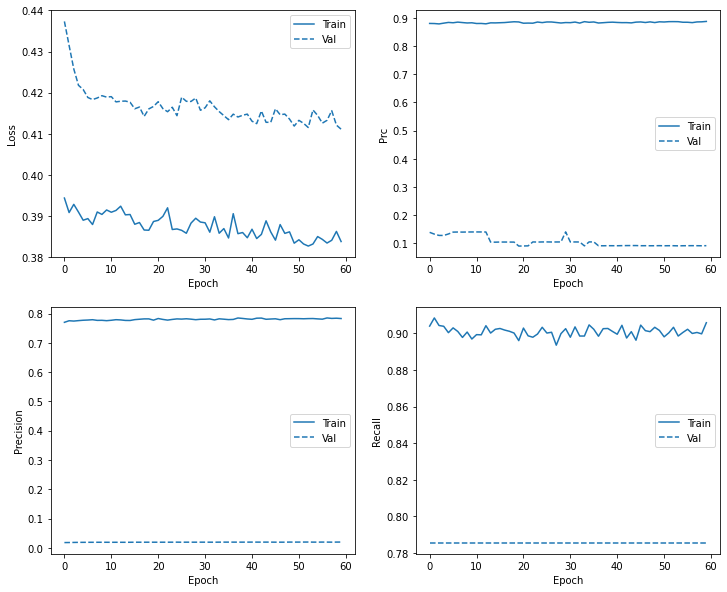

In [19]:
# Training history and metrics
plot_metrics(resampled_history)
resampled_results = resampled_model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

True Negatives:  2189
False Positives:  688
False Negatives:  1
True Positives:  17
Total faults:  18


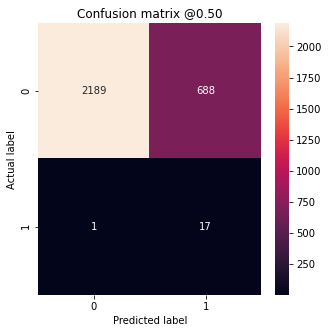

In [20]:
# Confusion matrix
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)
plot_cm(test_labels, test_predictions_resampled, p=0.5)

### ROC and AUPRC plots

- The ROC plot is useful because it shows, at a glance, the range of performance the model can reach just by tuning the output threshold.

- The AUPRC (Area under the interpolated precision-recall curve), is obtained by plotting (recall, precision) points for different values of the classification threshold. Depending on how it's calculated, PR AUC may be equivalent to the average precision of the model.

We compare the three methods in terms of these curves.

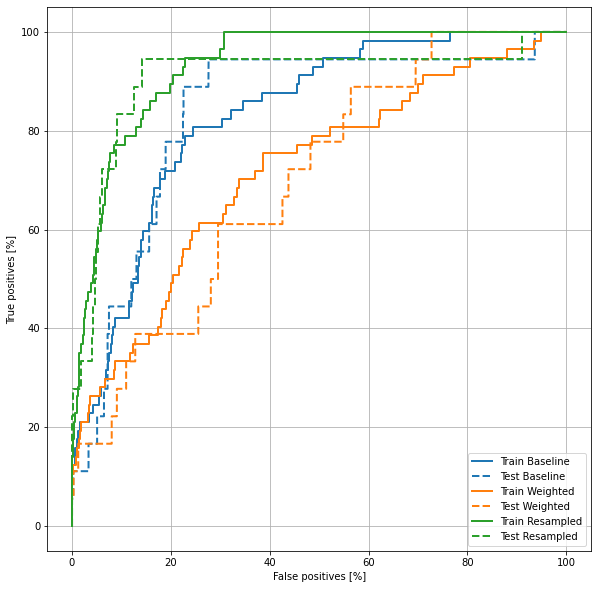

In [21]:
# ROC
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')


train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)

plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right')

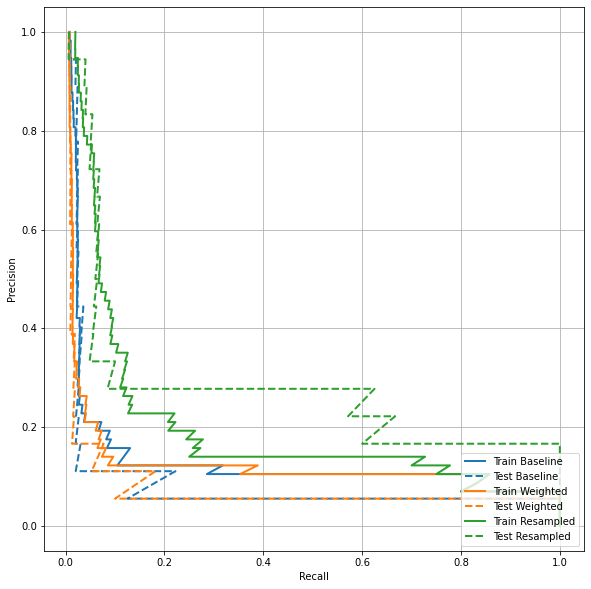

In [22]:
# AUPRC
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
    
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_prc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_prc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right')

In [23]:
f1_baseline = f1_score(test_labels, np.round(test_predictions_baseline))
f1_weighted = f1_score(test_labels, np.round(test_predictions_weighted))
f1_resampled = f1_score(test_labels, np.round(test_predictions_resampled))

print('F1 score:\n    baseline:  {:.3f}\n    weighted:  {:.3f}\n    resampled: {:.3f}'.format(f1_baseline, f1_weighted, f1_resampled))

F1 score:
    baseline:  0.105
    weighted:  0.105
    resampled: 0.047
